In [75]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import seaborn as sns
import matplotlib.pyplot as plt

In [76]:
#import pbp data for 2019-2023 seasons
seasons = range(2019, 2023 + 1)
pbp = nfl.import_pbp_data(seasons)

2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [77]:
pbp.shape

(243987, 390)

In [78]:
#Filter data down to passing plays only and exclude batted balls, throwaways, etc.
pbp_pass = pbp.query("play_type == 'pass' & air_yards.notnull()").reset_index()

In [79]:
pbp_pass.shape

(95075, 391)

In [80]:
#Check for null passing yard values
len(pbp_pass[pbp_pass['passing_yards'].isna()])

33570

In [81]:
#Replace null value passing yards with 0
pbp_pass['passing_yards'].fillna(0, inplace=True)

In [82]:
#Check again for null passing yard values
len(pbp_pass[pbp_pass['passing_yards'].isna()])

0

In [83]:
#Create a column to classify each play as 'short' or 'long' based on air yards
pbp_pass['pass_play_type'] = np.where(pbp_pass['air_yards'] >= 10, 'long', 'short')

<b>Visualize the Data

In [84]:
#Split the dataframe into short and long pass play types
pbp_pass_short = pbp_pass[pbp_pass['pass_play_type'] == 'short']
pbp_pass_long = pbp_pass[pbp_pass['pass_play_type'] == 'long']

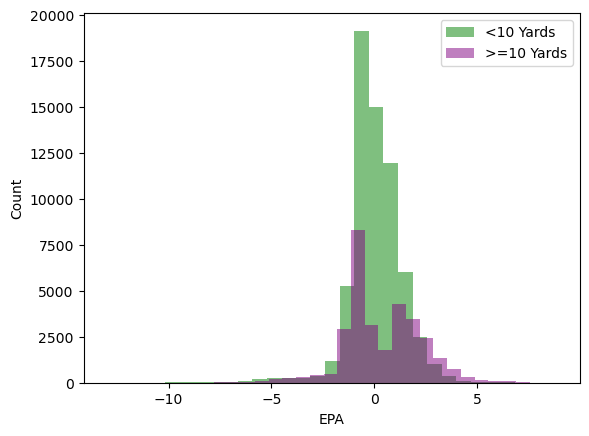

In [88]:
#Compare the distribution of Pass EPA for long passes vs short passes
plt.hist(pbp_pass_short['epa'], bins=30, alpha=0.5, label='<10 Yards', color='green')
plt.hist(pbp_pass_long['epa'], bins=30, alpha=0.5, label='>=10 Yards', color='purple')
plt.legend(loc='upper right')
plt.xlabel('EPA')
plt.ylabel('Count')
plt.show()

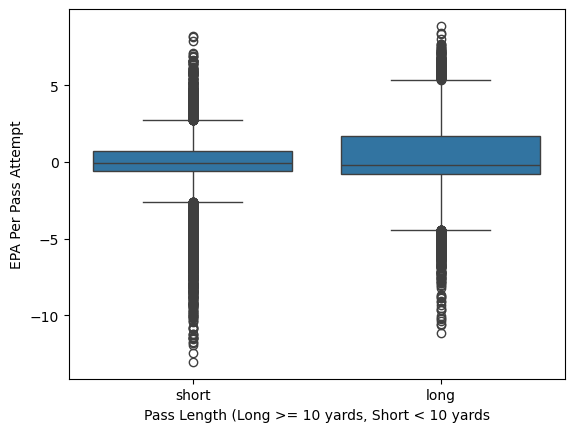

In [87]:
#Use a boxplot to compare the EPA of short passes vs long passes
epa_boxplot = sns.boxplot(data=pbp_pass, x='pass_play_type', y='epa');

epa_boxplot.set(
    xlabel='Pass Length (Long >= 10 yards, Short < 10 yards',
    ylabel='EPA Per Pass Attempt')

plt.show()

The plots show that there's a wider range of EPA outcomes for passes of 10+ air yards than there are for passes of less than 10 air yards. This lines up with our expectations, as long passes are more "high-risk, high-reward" than short passes.

<b>Stability Analysis of EPA per Pass Attempt

In [127]:
#Group all passing data by passer_id, passer, and season
pbp_pass_grouped = pbp_pass.groupby(['passer_id', 'passer', 'season']).agg({'epa': ['mean', 'count']})

In [128]:
#Reformat and rename the columns
pbp_pass_grouped.columns = list(map('_'.join, pbp_pass_grouped.columns.values))

pbp_pass_grouped.rename(columns={'epa_mean': 'avg_epa', 'epa_count': 'n'}, inplace=True)

In [129]:
#View the first 10 rows of the dataframe
pbp_pass_grouped.sort_values(by='avg_epa', ascending=False).head(10)

,,,avg_epa,n
passer_id,passer,season,,
00-0035544,T.Kennedy,2021,5.069598,1
00-0036320,J.Charlton,2020,4.732203,1
00-0022824,A.Lee,2019,4.240687,1
00-0036313,B.Mann,2023,4.209327,1
00-0033557,J.Reeves-Maybin,2023,4.143003,1
00-0035889,T.Townsend,2021,4.030698,1
00-0022824,A.Lee,2020,4.014011,1
00-0029692,B.Anger,2021,3.856170,1
00-0031941,J.Crowder,2020,3.846167,1


In [130]:
#Filter the dataframe on passers with more than 100 attempts
pbp_pass_grouped = pbp_pass_grouped.query('n > 100').sort_values(by='avg_epa', ascending=False)
pbp_pass_grouped.head(10)

avg_epa    n
passer_id  passer       season               
00-0037834 B.Purdy      2023    0.389934  548
00-0023459 A.Rodgers    2020    0.387941  607
00-0029701 R.Tannehill  2019    0.383158  343
00-0037834 B.Purdy      2022    0.370602  233
00-0033537 D.Watson     2020    0.360062  542
00-0034796 L.Jackson    2019    0.357564  457
00-0026498 M.Stafford   2019    0.356962  289
00-0033873 P.Mahomes    2022    0.337131  748
                        2019    0.336143  596
00-0036212 T.Tagovailoa 2022    0.330150  399

Perform a year-over-year comparison

In [145]:
#Group data by passer_id, passer, season, and pass play type
pbp_pass_grouped_length = (pbp_pass.groupby(['passer_id', 'passer', 'season', 'pass_play_type']).agg({'epa': ['mean', 'count']}))

In [146]:
#Reformat and rename columns
pbp_pass_grouped_length.columns = list(map('_'.join, pbp_pass_grouped_length.columns.values))

pbp_pass_grouped_length.rename(columns={'epa_mean': 'avg_epa', 'epa_count': 'n'}, inplace=True)

In [147]:
pbp_pass_grouped_length.reset_index(inplace=True)
pbp_pass_grouped_length.head()

,passer_id,passer,season,pass_play_type,avg_epa,n
0,00-0019596,T.Brady,2019,long,0.392257,191
1,00-0019596,T.Brady,2019,short,-0.030342,459
2,00-0019596,T.Brady,2020,long,0.506909,268
3,00-0019596,T.Brady,2020,short,0.148152,476
4,00-0019596,T.Brady,2021,long,0.451568,263


In [150]:
#Filter query for records of 30+ long passes or 100+ short passes
pbp_pass_grrouped_length = pbp_pass_grouped_length.query(
    "(n >= 30 & pass_play_type == 'long') | n >= 100 & pass_play_type == 'short'")

In [151]:
#Create a copy of the dataframe, but exclude n
cols_save = ['passer_id', 'passer', 'season', 'pass_play_type', 'avg_epa']

epa_df = pbp_pass_grouped_length[cols_save].copy()

In [153]:
#Create another copy of the dataframe
epa_df_lag = epa_df.copy()

#Edit the season column to add 1 to each value
epa_df_lag['season'] += 1

#Rename avg_epa to avg_epa_last
epa_df_lag.rename(columns = {'avg_epa': 'avg_epa_last'}, inplace=True)

In [156]:
#Merge the two dataframes
total_epa_df = epa_df.merge(
    epa_df_lag,
    how='inner',
    on=['passer_id', 'passer', 'season', 'pass_play_type'])

In [157]:
total_epa_df.head()

,passer_id,passer,season,pass_play_type,avg_epa,avg_epa_last
0,00-0019596,T.Brady,2020,long,0.506909,0.392257
1,00-0019596,T.Brady,2020,short,0.148152,-0.030342
2,00-0019596,T.Brady,2021,long,0.451568,0.506909
3,00-0019596,T.Brady,2021,short,0.123760,0.148152
4,00-0019596,T.Brady,2022,long,0.194146,0.451568


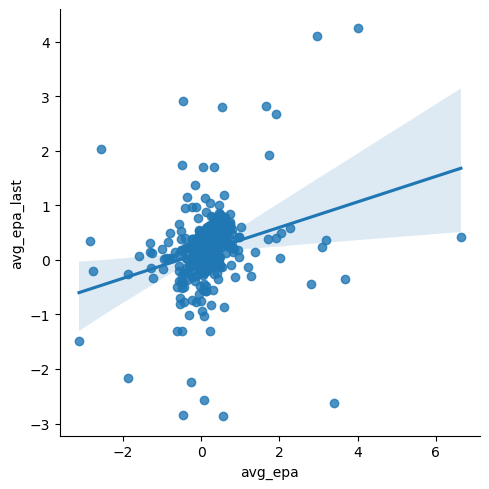

In [158]:
#Plot avg_epa vs avg_epa_last for all pass types
sns.lmplot(data=total_epa_df, x='avg_epa', y='avg_epa_last');
plt.show();

In [159]:
#Use Pearson's correlation to group by long/short passes and visualize correlation in a data frame
(total_epa_df.query('avg_epa.notnull() & avg_epa_last.notnull()')
    .groupby('pass_play_type')[['avg_epa', 'avg_epa_last']]
    .corr()
)

avg_epa  avg_epa_last
pass_play_type                                     
long           avg_epa       1.000000      0.221858
               avg_epa_last  0.221858      1.000000
short          avg_epa       1.000000      0.266058
               avg_epa_last  0.266058      1.000000

There is a stronger year-over-year correlation between average EPA of short passes vs long passes, but the stronger corelation is not significant.